# Classification: $H \rightarrow ZZ \rightarrow 4\ell$<br>
 
## Introduction
In this notebook, we build a machine learning model (a simple neural network) to discriminate between two classes of events, $H \rightarrow ZZ \rightarrow 4\ell$ produced via vector-boson fusion (__vbf__) and the same final state produced via gluon-gluon fusion (__ggF__). We use __supervised learning__ in which the data instances $x$ that characterize the objects to be classified, here Higgs boson events,  are unambiguously labeled by the class to which the instances belong. The class labels $y$ are referred to as __targets__. We shall use $y = 0$ for ggf events and $y = 1$ for vbf events.

The data are read from __csv__ files, each row of which contains quantities that characterize $H \rightarrow ZZ \rightarrow 4\ell$ events. In __machine learning__, these quantities are often referred to as __features__ and form __feature vectors__. We use the following features $\boldsymbol{x} \equiv (|\Delta\eta_{jj}|, m_{jj})$ where $|\Delta\eta_{jj}|$ is the di-jet absolute pseudorapidiy difference (detajj) and $m_{jj}$ the di-jet mass (massjj). 

### Required modules

In [3]:
# standard system modules
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
# standard module to serialize, that is, save, objects
import joblib as jb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# to reload modules
import importlib

2025-09-10 18:47:12.196927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load Higgs boson data into memory

In [6]:
train_data = pd.read_csv('datasets/hzz_vbf_ggf_train.csv') 
test_data  = pd.read_csv('datasets/hzz_vbf_ggf_test.csv')
print('training data set size: %5d' % len(train_data))
print('testing data set size:  %5d' % len(test_data))
train_data[:5]

training data set size: 50000
testing data set size:  10000


,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,90.29,14.06,215.80,-0.1829,86.08,0.3362,324.5,0.4905,0.0
1,86.57,37.24,217.80,0.3579,310.20,2.8900,219.9,0.1691,0.0
2,97.37,13.46,138.90,-0.8100,220.40,2.9030,106.3,0.4296,0.0
3,91.96,18.97,54.89,-2.6840,583.50,5.0130,101.6,1.7580,1.0
4,91.45,12.06,187.80,-0.5866,55.98,0.3771,220.2,0.6852,1.0


### Specify features to be used for the classifier.

In [7]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   8
XMIN  =   0
XMAX  =   8
XSTEP =   2

YBINS =  10
YMIN  =   0
YMAX  =2000
YSTEP = 400

features = [XNAME, YNAME]
target   = 'target'

In [8]:
# split into signal and background events
sig = train_data[train_data['target'] > 0]
bkg = train_data[train_data['target'] < 1]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
x, y = np.meshgrid(x, y)

# WARNING: must transpose z so that x, y, and z have the
# same shape
d = np.where(s + b <= 0, 1e10, s + b)
z = s / d
H = (x, y, z.T)

K = 10000
t = test_data[:K]
sig = t[t['target'] > 0]
bkg = t[t['target'] < 1]
print(len(sig), len(bkg), len(sig)+len(bkg))

5000 5000 10000


### Plot data

In [9]:
def plot_data(vbf, ggf, H=None, 
              filename='higgs_vbf_ggf_variables.png',
              xmin=XMIN, xmax=XMAX, xstep=XSTEP, 
              xname=XNAME, xlabel=XLABEL,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              yname=YNAME, ylabel=YLABEL,
              N=1000, 
              ftsize=FONTSIZE):
    
    # set size of figure
    fig = plt.figure(figsize=(5, 5))

    # set axes' limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(xlabel, fontsize=ftsize)
    plt.xticks(np.arange(xmin, xmax+xstep, xstep))
    
    plt.ylabel(ylabel, fontsize=ftsize)
    plt.yticks(np.arange(ymin, ymax+ystep, ystep))

    plt.scatter(vbf.detajj, vbf.massjj, marker='o',
                s=30, c='blue', alpha=0.3, label='VBF')
    plt.legend(loc='upper left') # activate legend
    
    plt.scatter(ggf.detajj, ggf.massjj, marker='*',
                s=80, c='red',  alpha=0.4, label='ggF')
    plt.legend(loc='upper left') # activate legend
    
    if H:
        X, Y, Z = H
        mylevels = np.arange(0.1, 1, 0.1)
        cs = plt.contour(X, Y, Z, levels=mylevels, cmap='rainbow_r')
        plt.clabel(cs, cs.levels, inline=True, 
              fontsize=18, fmt='%4.2f', 
              colors='black')
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

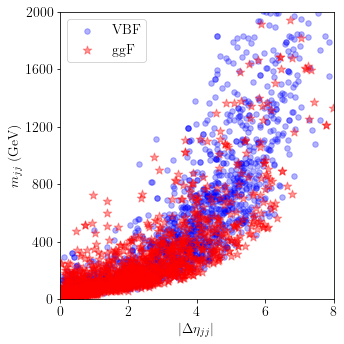

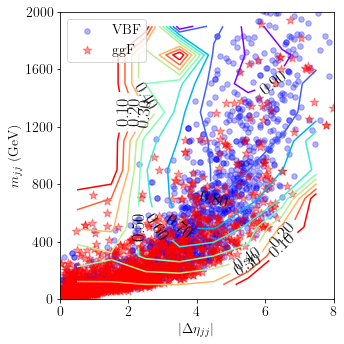

In [36]:
N = 1500
plot_data(sig[:N], bkg[:N], 
          filename='higgs_vbf_ggf_data.png')

plot_data(sig[:N], bkg[:N], H=H,
          filename='higgs_vbf_ggf_data_based_contours.png')

### Train, validation, and test sets

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

### Prepare data

In [10]:
# Split the training data into a part for fitting and
# a part for validation during training.
fraction = 1/10
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes (and drop the old ones)
# so that the indices start from zero and increment by one
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][features]

train set size:         45000
validation set size:     5000
test set size:          10000


,detajj,massjj
0,5.390,782.6
1,4.245,531.9
2,3.174,1359.0
3,5.114,477.9
4,4.549,636.4


Transform data and split data into targets $t$ and inputs $\mathbf{x}$

In [11]:
# create object to transform source (i.e., input) data 
scaler  = StandardScaler()
scaler.fit(train_data[features])

def split_t_x(df, target, source, scaler):
    # change from pandas dataframe format to a numpy array
    t = np.array(df[target])
    x = np.array(scaler.transform(df[source]))
    return (t, x)

train_t, train_x = split_t_x(train_data, target, features, scaler)
valid_t, valid_x = split_t_x(valid_data, target, features, scaler)
test_t,  test_x  = split_t_x(test_data,  target, features, scaler)
train_t[:5], train_x[:5]

(array([1., 1., 1., 1., 1.]),
 array([[1.29547939, 0.68123889],
        [0.69298651, 0.18918651],
        [0.12943204, 1.81254719],
        [1.15024967, 0.08319996],
        [0.85294969, 0.39429011]]))

### Return a (random) batch of data from the training set

In [12]:
def randomBatch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from 
    # the range [0, length-1] 
    rows    = rnd.choice(len(x), batch_size)
    # pick out rows defined by the integers in array "rows"
    batch_x = x[rows]
    batch_t = t[rows]
    return batch_x, batch_t

This function is used to validate the model while it is being fitted.

In [ ]:
def validate(model, inputs, targets):
    loss = model.evaluate(inputs, targets, verbose=0)
    return loss

### Define model $f(\mathbf{x}, \theta)$


In [15]:
def build_model(n_inputs=2, n_nodes=50, n_layers=2):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_inputs,)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_nodes, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

### Function to execute training loop

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,777 (421.00 KB)

 Trainable params: 107,777 (421.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
1407/1407 - 5s - 3ms/step - accuracy: 0.6902 - loss: 0.6015 - val_accuracy: 0.6862 - val_loss: 0.5958 - learning_rate: 1.0000e-03
Epoch 2/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6926 - loss: 0.5925 - val_accuracy: 0.6906 - val_loss: 0.5936 - learning_rate: 1.0000e-03
Epoch 3/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6944 - loss: 0.5906 - val_accuracy: 0.6918 - val_loss: 0.5951 - learning_rate: 1.0000e-03
Epoch 4/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6938 - loss: 0.5905 - val_accuracy: 0.6888 - val_loss: 0.5886 - learning_rate: 1.0000e-03
Epoch 5/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6921 - loss: 0.5889 - val_accuracy: 0.6862 - val_loss: 0.5907 - learning_rate: 1.0000e-03
Epoch 6/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6933 - loss: 0.5884 - val_accuracy: 0.6916 - val_loss: 0.5903 - learning_rate: 1.0000e-03
Epoch 7/300
1407/1407 - 3s - 2ms/step - accuracy: 0.6927 - loss: 0.5884 - val_accuracy: 0.6908 - val_loss: 0.5907 - learning_rate: 1.0000e-03
Epoch 

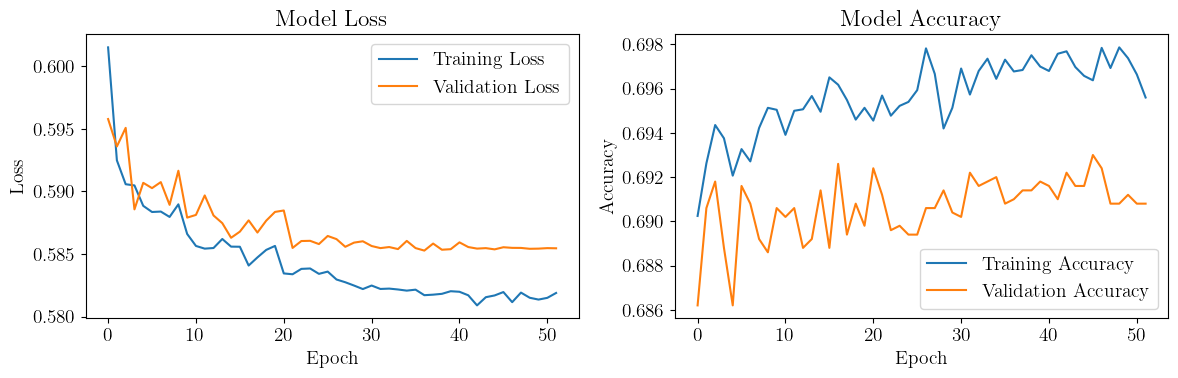

In [18]:
def build_model_improved(n_inputs=2, n_nodes=128, n_layers=4):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_inputs,)))
    
    model.add(layers.Dense(n_nodes, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    for i in range(n_layers-1):
        nodes = n_nodes // (2**i)  # Diminuisce gradualmente
        model.add(layers.Dense(max(nodes, 32), activation='relu'))
        model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

model = build_model_improved(n_inputs=2, n_nodes=256, n_layers=4)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # LR più alto
    loss='binary_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

model.summary()

history = model.fit(
    train_x, train_t,
    validation_data=(valid_x, valid_t),
    epochs=300,        # Più epochs
    batch_size=32,     # Batch size più piccolo
    callbacks=callbacks,
    verbose=2
)

plot_keras_history(history)

### Train!

Instantiate a model, an optimizer, then train

In [19]:
def number_of_parameters(model):
    return model.count_params()

### Plot distribution of model output 

In [20]:
def compute(model, x):
    # Con TensorFlow/Keras è molto più semplice!
    y = model.predict(x, verbose=0)
    return y.flatten()  # Appiattisci a 1D

test_y = compute(model, test_x)

In [22]:
def plot_distribution(y, t, 
                      nbins=50, 
                      ftsize=FONTSIZE, 
                      fgsize=(5, 5)):

    # select the model output results for VBF events
    vbf = y[t > 0.5]
    
    # select the model output results for ggF events
    ggf = y[t < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.ylim(0, 4)
    
    plt.hist(ggf, 
             bins=nbins, 
             color=(1,0,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggF)') 
    plt.legend(fontsize='small')
    
    plt.hist(vbf, 
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (VBF)')
    plt.legend(fontsize='small')

    plt.savefig("hzz_distributions.png")
    plt.show()

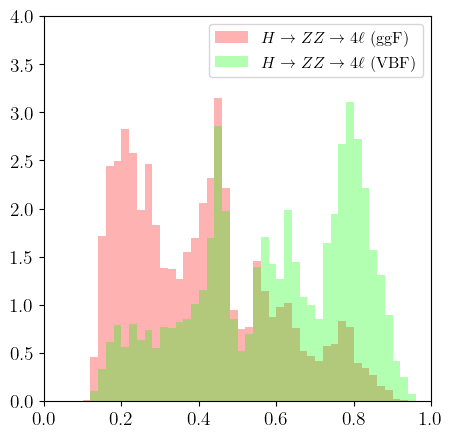

In [23]:
plot_distribution(test_y, test_t)

### Plot Receiver Operating Characteristic (ROC) curve

In [24]:
def plot_ROC(y, p):
    bad, good, _ = roc_curve(y, p)
    roc_auc = auc(bad, good)
    plt.figure(figsize=(5, 5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction of ggF events', fontsize=14)
    plt.ylabel('fraction of VBF events', fontsize=14)
    
    plt.plot(bad, good, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

    plt.legend(loc="lower right", fontsize=14)
    
    plt.savefig("hzz_ROC.png")
    plt.show()

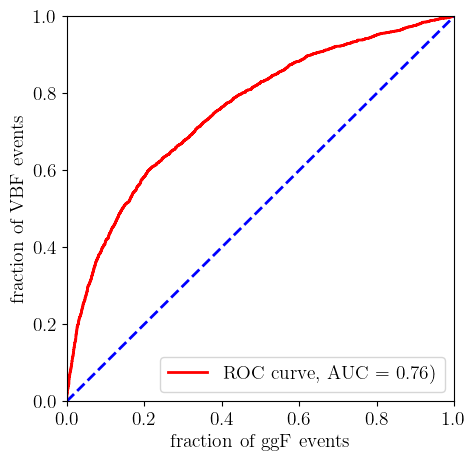

In [25]:
plot_ROC(test_t, test_y)

In [26]:
def compute_dnn_contours(dnn, scaler,                  
                 xmin=XMIN, xmax=XMAX, 
                 ymin=YMIN, ymax=YMAX):
    # 1. first create a mesh
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin, xmax, xdelta)
    yy     = np.arange(ymin, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # convert mesh to a dataframe
    XY     = pd.DataFrame({'detajj': X.flatten(), 
                           'massjj': Y.flatten()})
   
    # apply standardization to data
    XY = scaler.transform(XY)
    
    # compute model output at every grid point
    # then reshape to an (npoints x npoints) array
    Z = compute(dnn, XY).reshape([npoints, npoints])
    return (X, Y, Z)

In [27]:
dnn_H = compute_dnn_contours(model, scaler)